# CMSC 636, HW4: Restricted Boltzman Machine on MNIST

In [17]:
import numpy as np
import tensorflow as tf
from types import SimpleNamespace

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import clear_output
%matplotlib inline

## Load MNIST

In [18]:
# load mnist dataset with labels encoded as one-hot vectors
class Dataset():
    def __init__(self, data):
        self.data = data
        self.index = 0
        self.epochs = 0

    def shuffle(self):
        perm = np.arange(self.data[0].shape[0])
        np.random.shuffle(perm)
        self.data = tuple(datai[perm] for datai in self.data)
    
    def next_batch(self, batch_size):
        start = self.index
        end = self.index + batch_size
        if end > self.data[0].shape[0]:
            self.epochs += 1
            self.shuffle()
            self.index, start = 0, 0
            end = batch_size
        self.index = end
        return tuple(datai[start:end, ...] for datai in self.data)
            
def load_mnist():
    def preprocess(data, labels, num_classes):
        # flatten images
        data = data.astype(np.float32)/255.0
        data = np.reshape(data, [data.shape[0], -1])
        # one hot encoding
        num_labels = labels.shape[0]
        index_offset = np.arange(num_labels) * num_classes
        labels_one_hot = np.zeros((num_labels, num_classes))
        labels_one_hot.flat[index_offset + labels.ravel()] = 1
        return data, labels_one_hot
    train, test = tf.keras.datasets.mnist.load_data()
    train = preprocess(train[0], train[1], 10)
    test = preprocess(test[0], test[1], 10)
    return SimpleNamespace(
        train=Dataset(train), 
        test=Dataset(test))
mnist = load_mnist()

## Model definition

In [19]:
sess = tf.InteractiveSession()

In [20]:
def bernoulli_sample_tf(x):
    ''' sample from bernoulli distribution given a tf matrix '''
    in_shape= x.get_shape().as_list()
    uniform_samp = tf.random_uniform(shape=(in_shape[0], in_shape[1]), minval=0.0, maxval=1.0) 
    return tf.to_float(tf.greater(x, uniform_samp))

Implement the contrastive divergence update rule for the rbm, using a mini-batch of  𝑀  samples:

𝑊←𝑊+𝛼Δ𝑊  
𝑏←𝑏+𝛼Δ𝑏  
𝑐←𝑐+𝛼Δ𝑐  

Where:

𝑊∈×,b∈,c∈  

𝑋∈×  , is the matrix composed by the training samples in the mini-batch. Each row of  𝑋  is a training sample 

Δ𝑊=1𝑀(𝑋𝑇ℎ(𝑥)−𝑋𝑇𝑠ℎ(𝑋𝑠))  

Δ𝑏=𝑚𝑒𝑎𝑛((ℎ(𝑋)−ℎ(𝑋𝑠)))  

Δ𝑐=𝑚𝑒𝑎𝑛((𝑋−𝑋𝑠))  

ℎ(𝑋)=𝜎(𝑋𝑊+𝑏);𝜎(𝑥)=11+exp(−𝑥) 
Note: The model uses Bernoulli visible and hidden layers

In [25]:
n_inputs= 28*28 # Complete: number of input units (i.e. V)
n_hidden=   20 # Complete: number of hidden units (i.e. H), try different values
batch_size= 500 # number of samples on the mini-batch (i.e. M)

k= 20          #Try different values 
alpha= 0.1   #Try different values

X = tf.placeholder( tf.float32, shape=(batch_size, n_inputs))

W= tf.Variable(tf.zeros([n_inputs, n_hidden])) # Complete: weight matrix for the rbm model
b= tf.Variable(tf.zeros([batch_size, n_hidden]))# Complete: b vector for the rbm model
c= tf.Variable(tf.zeros([batch_size, n_inputs]))# Complete: c vector for the rbm model

# K gibbs sampling: obtain a set of samples Xs by performing K-gibbs sampling steps
Xs = X;
for i in range(k):
    hs_prob = tf.sigmoid(tf.matmul(Xs, W) + b)
    hs = bernoulli_sample_tf(hs_prob)
    Xs_prob = tf.sigmoid(tf.matmul(hs, tf.transpose(W)) + c)
    Xs = bernoulli_sample_tf(Xs_prob)
    
# Parameter update:
h_x =  tf.sigmoid(tf.matmul(X,W) + b)# Complete: compute h(X)
h_xs = tf.sigmoid(tf.matmul(Xs,W) + b)# Complete: compute h(Xs)

dW = 1/batch_size * (tf.matmul(tf.transpose(X),h_x) - tf.matmul(tf.transpose(Xs),h_xs))# Complete: follow update equations

db = 1/k * (h_x - h_xs)# Complete: follow update equations
dc = 1/k * (X - Xs)  # Complete: follow update equations

op_W= W.assign_add( alpha*dW )
op_b= b.assign_add( alpha*db )
op_c= c.assign_add( alpha*dc )

update_weights = tf.group( op_W, op_b, op_c )



In [26]:
# For visualization of the samples from the model
# K gibbs sampling starting from random hidden layer
hst = tf.random_uniform(shape=(batch_size, n_hidden), minval=0, maxval=1)
for i in range(10):
    Xst_prob = tf.sigmoid(tf.matmul(hst, tf.transpose(W)) + c)
    Xst = bernoulli_sample_tf(Xst_prob)
    hst_prob = tf.sigmoid(tf.matmul(Xst, W) + b)
    hst = bernoulli_sample_tf(hst_prob)

## Train the model

In [27]:
init = tf.global_variables_initializer()
sess.run(init)
print('Initialized')

Initialized


Samples generated starting from given X


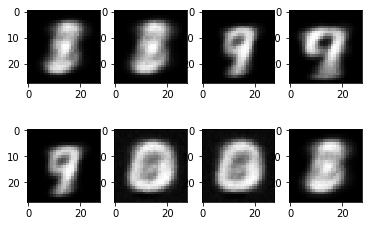

Samples generated from random H


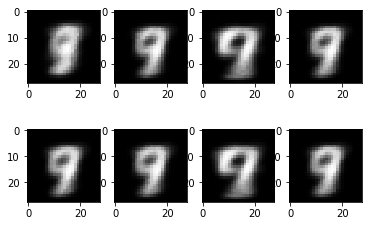

KeyboardInterrupt: 

In [29]:
num_steps= 10000 # try different values
n_logging = 500  # try different values

for step in range(num_steps):
    # -------- train RBM -----#
    batch_x, _= mnist.train.next_batch(batch_size) 
    [_, x_g] = sess.run([update_weights, Xs_prob], feed_dict= {X : batch_x})
    
    #  ------- logging -------
    if step%n_logging == 0:
        clear_output()
        
        # --- plot samples starting from given x --- #
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(1)
        print('Samples generated starting from given X')
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()
        
        # --- plot random samples --- #
        [x_g] = sess.run([Xst_prob], feed_dict= {X : batch_x})
        x_gaux = np.reshape(x_g, [-1,28,28,1])
        
        plt.figure(2)
        print('Samples generated from random H')
        for i in range(2*4):
            plt.subplot(241 + i)
            plt.imshow(x_gaux[i,:,:,0], cmap='Greys_r')
        plt.show()